## Homework 9 - Jakub Kuśmierski

### Initialization of the environment

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools
import pandas as pd

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import text_functions as txt_fcn
importlib.reload(txt_fcn);

#import text_functions as txt_fcn
#importlib.reload(txt_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

### Functions

In [2]:
###################################################
def map_fn(x):
    middle = 2
    features =  tf.concat((x[:,:middle], x[:,middle+1:]), axis=1)
    label = x[:,middle]
    return features, label
###################################################
def print_item(batch, vocabulary, width=2):
    batch_index = 0
    item = (batch[0][batch_index], batch[1][batch_index])
    features = " ".join(vocabulary[item[0].numpy()[0:width]])
    label = vocabulary[item[1].numpy()]
    print(colored("Features", "blue"), end=" ")
    print(colored("(Label):", "red"), end=" ")

    print(features, end=" ")
    print(colored(label,"red"), end=" ")
    features = " ".join(vocabulary[item[0].numpy()[width:]])
    print(features)
###################################################

### Data preparation

In [3]:
# load text
filePath = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
dataset = txt_fcn.load_wksf_dataset(filePath)

# adapt vextorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode = "int")
vectorize_layer.adapt(dataset.batch(128))

# split lines into words
dataset = dataset.map(tf_text.WhitespaceTokenizer().tokenize)

# fix all tf_text.sliding_window function arguments except for the input data
window_size = 5
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

# apply the sliding window to each line.
# this will produce a tensor of shape (n, width) for each line,
# where n in the number of groups of words with length width
dataset = dataset.map(slidingWindowWithWidth)

# remove empty lines
dataset = dataset.filter(lambda x: tf.size(x) > 0)

# split the (n, width) tensor into (n) tensors of shape (width)
dataset = dataset.unbatch()

# merge words into sentence framgents
dataset = dataset.map(lambda x: tf.strings.reduce_join(x, separator=' '))

#Vectorize
vectorize_layer = tf.keras.layers.TextVectorization(output_mode="int")
vectorize_layer.adapt(dataset.batch(1024))
vocabulary = np.array(vectorize_layer.get_vocabulary())
vocabulary_length = vocabulary.shape[0]
dataset_vectorized = dataset.batch(1024).map(vectorize_layer, num_parallel_calls=tf.data.AUTOTUNE).unbatch()
dataset_vectorized = dataset_vectorized.filter(lambda x: tf.math.count_nonzero(x==1, axis=0) < 2)
print(colored("Vocabulary length: ", "green"), vocabulary_length)

dataset_final = dataset_vectorized.batch(32).map(map_fn)

for item in dataset_final.take(5):
    print_item(item, vocabulary, width=2)
    print(colored("Features: ", "blue"), item[0][0].numpy(), end=" ")
    print(colored("Label: ", "blue"), item[1][0].numpy())


Reading text from files:  ['/Users/jakubkusmierski/.keras/datasets/shakespeare.txt']
Vocabulary length:  12563
Features (Label): before we proceed any further
Features:  [128  33 123 639] Label:  1267
Features (Label): are accounted poor citizens the
Features:  [  40 7153 1196    2] Label:  149
Features (Label): is a gain to them
Features:  [12  7  4 62] Label:  1109
Features (Label): services he has done for
Features:  [1501   22  146   14] Label:  271
Features (Label): was for his country he
Features:  [ 51  14 600  22] Label:  20


### Embedding layer without training

In [4]:
nTokens = vocabulary_length
nDims = 128 
embedding_layer = tf.keras.layers.Embedding(nTokens, nDims)

# Embeding space exploration - words similar to "man"
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))

word = "man"

word_index = np.where(vocabulary == word)[0][0]
word_vector = vocabulary_embedding[word_index]

print(colored("Word embedding:", "blue"), word_vector.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)

similarities = -tf.keras.losses.cosine_similarity(word_vector, vocabulary_embedding, axis=-1)
top_k_values, top_k_indices = tf.math.top_k(similarities, k=5)
top_k_words = tf.gather(vocabulary, top_k_indices)


print(colored("Words similar to '{}'".format(word), "green"))
for i, sim_word in enumerate(top_k_words):
    print(colored("{:2d}: {}".format(i+1, sim_word.numpy().decode("utf-8")), "yellow"), end=" ")
    print(colored("({:.4f})".format(top_k_values[i].numpy()), "cyan"))



pass

Word embedding: (128,)
Vocabulary embedding: (12563, 128)
Words similar to 'man'
 1: man (1.0000)
 2: discoverd (0.3454)
 3: ive (0.2996)
 4: learning (0.2994)
 5: calld (0.2966)


### Word arithmetics without training

In [5]:
# Word arithmetics - words similar to "mother" + "father"
words = np.array(["father", "mother"])

word_index = [np.where(vocabulary == x)[0][0] for x in words]
word_vector = tf.gather(vocabulary_embedding, word_index)

print(colored("Word embedding:", "blue"), word_vector.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)

word_embedding = word_vector[0] + word_vector[1]

similarities = -tf.keras.losses.cosine_similarity(word_embedding, vocabulary_embedding, axis=-1)
top_k_values, top_k_indices = tf.math.top_k(similarities, k=5)
top_k_words = tf.gather(vocabulary, top_k_indices)


print(colored("Words similar to '{}'".format(words), "green"))
for i, sim_word in enumerate(top_k_words):
    print(colored("{:2d}: {}".format(i+1, sim_word.numpy().decode("utf-8")), "yellow"), end=" ")
    print(colored("({:.4f})".format(top_k_values[i].numpy()), "cyan"))

pass

Word embedding: (2, 128)
Vocabulary embedding: (12563, 128)
Words similar to '['father' 'mother']'
 1: mother (0.7772)
 2: father (0.7507)
 3: created (0.3287)
 4: howeer (0.3030)
 5: prescience (0.2961)


### Training

CPU times: user 1e+03 ns, sys: 7 μs, total: 8 μs
Wall time: 22.9 μs


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 4, 128)         │     1,608,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 1, 128)         │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_5 (Dot)                     │ (None, 12563)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608,064 (6.13 MB)

 Trainable params: 1,608,064 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0028 - loss: 9.4389
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.0477 - loss: 9.3737 - val_accuracy: 0.0840 - val_loss: 9.2031
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.1147 - loss: 8.9751 - val_accuracy: 0.0859 - val_loss: 9.0409
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.1426 - loss: 8.5928 - val_accuracy: 0.0859 - val_loss: 8.9300
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.1605 - loss: 8.2529 - val_accuracy: 0.0898 - val_loss: 8.8515
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.1793 - loss: 7.9479 - val_accuracy: 0.0918 - val_loss: 8.7915
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.1966 - loss: 7.6689 - val_accuracy: 0.0938 - val_loss: 8.7455
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.2142 - loss: 7.4096 - val_accuracy: 0.0918 - val_loss: 8.7105
Epoch 8/1

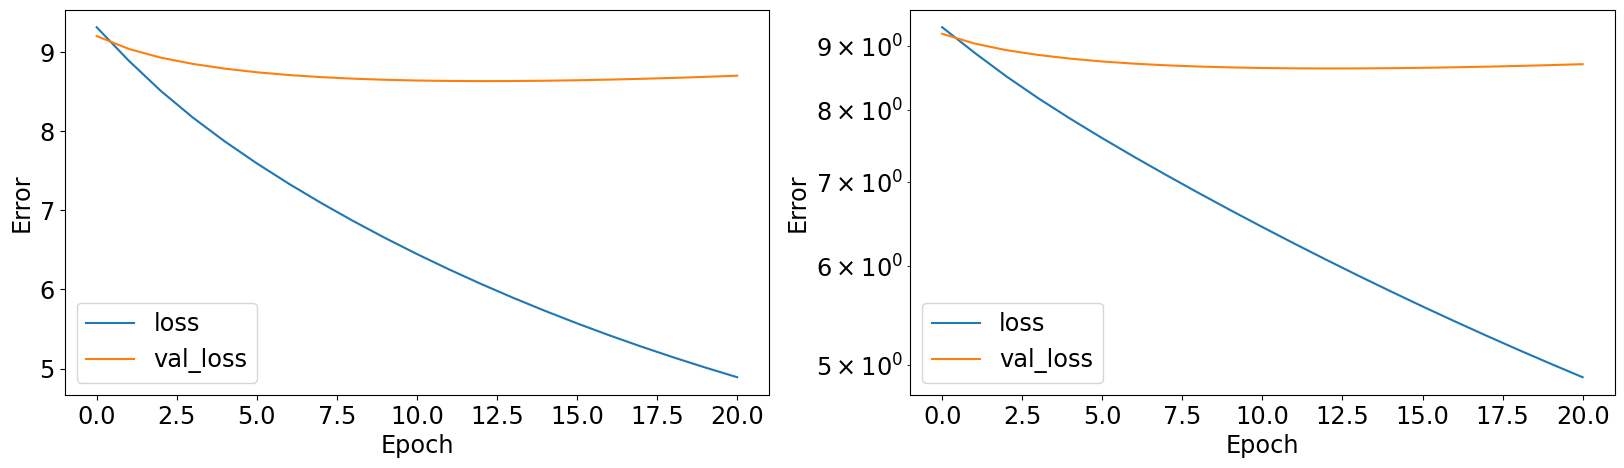

In [13]:
%time
# CBOW model training (optional)
class Dot(tf.keras.Layer):
    def call(self, x):
        dot_product = tf.math.multiply(x[0], x[1])
        dot_product = tf.math.reduce_sum(dot_product, axis=2)
        return dot_product
    
    
nTokens = vocabulary_length
nDims = 128 
embedding_layer = tf.keras.layers.Embedding(nTokens, nDims, name="embedding")

input_layer = tf.keras.Input(shape=(window_size-1,), dtype=tf.int32, name="input")
context_layer = embedding_layer(input_layer)
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))
context_mean = tf.keras.layers.GlobalAveragePooling1D(keepdims=True)(context_layer)

dot_product = Dot()([context_mean, vocabulary_embedding])

model= tf.keras.Model(inputs=input_layer, outputs=dot_product)
model.summary()



nEpochs = 100
initial_learning_rate = 2E-2
nStepsPerEpoch = 500

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=loss, metrics=['accuracy'])


#Evaluate non trained model
model.evaluate(dataset_final.take(16))

#Training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,   
                                                       patience=5, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset_final.skip(16).take(nStepsPerEpoch),
                    validation_data=dataset_final.take(16),
                    callbacks=callbacks,
                    epochs=nEpochs, verbose=1)

model.evaluate(dataset_final.take(16))

plf.plotTrainHistory(history)



pass

### Embedding layer with training

In [14]:
embedding_layer = model.get_layer("embedding")
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))

word = "man"

word_index = np.where(vocabulary == word)[0][0]
word_vector = vocabulary_embedding[word_index]

print(colored("Word embedding:", "blue"), word_vector.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)

similarities = -tf.keras.losses.cosine_similarity(word_vector, vocabulary_embedding, axis=-1)
top_k_values, top_k_indices = tf.math.top_k(similarities, k=5)
top_k_words = tf.gather(vocabulary, top_k_indices)


print(colored("Words similar to '{}'".format(word), "green"))
for i, sim_word in enumerate(top_k_words):
    print(colored("{:2d}: {}".format(i+1, sim_word.numpy().decode("utf-8")), "red"), end=" ")
    print(colored("({:.4f})".format(top_k_values[i].numpy()), "cyan"))

Word embedding: (128,)
Vocabulary embedding: (12563, 128)
Words similar to 'man'
 1: man (1.0000)
 2: doit (0.5724)
 3: christianlike (0.5189)
 4: sweeter (0.5049)
 5: theft (0.4955)


### Word arithmetics with training

In [16]:
embedding_layer = model.get_layer("embedding")
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))

words = np.array(["father", "mother"])

word_index = [np.where(vocabulary == x)[0][0] for x in words]
word_vector = tf.gather(vocabulary_embedding, word_index)

print(colored("Word embedding:", "blue"), word_vector.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)

word_embedding = word_vector[0] + word_vector[1]

similarities = -tf.keras.losses.cosine_similarity(word_embedding, vocabulary_embedding, axis=-1)
euclidean_distance = tf.norm(word_embedding - vocabulary_embedding, axis=-1)
top_k_values, top_k_indices = tf.math.top_k(similarities, k=5)
#top_k_values, top_k_indices = tf.math.top_k(-euclidean_distance, k=5)
top_k_words = tf.gather(vocabulary, top_k_indices)


print(colored("Words similar to '{}'".format(words), "green"))
for i, sim_word in enumerate(top_k_words):
    print(colored("{:2d}: {}".format(i+1, sim_word.numpy().decode("utf-8")), "red"), end=" ")
    print(colored("({:.4f})".format(top_k_values[i].numpy()), "cyan"))

Word embedding: (2, 128)
Vocabulary embedding: (12563, 128)
Words similar to '['father' 'mother']'
 1: mother (0.8383)
 2: father (0.8057)
 3: allies (0.6549)
 4: advancement (0.6531)
 5: armd (0.6410)
